In [1]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

Предобработка аудио
- Сэмплирование: Аудио преобразуется в цифровой формат с определенной частотой дискретизации.
- Нормализация: Приведение громкости к единому уровню.
- Фильтрация: Удаление шумов и ненужных частот.

Для анализа аудио часто извлекаются следующие характеристики:
- Мел-частотные кепстральные коэффициенты (MFCC): Описывают спектральные свойства звука и используются в задачах распознавания речи.
- Спектрограмма: Графическое представление амплитуды частот во времени, помогает визуализировать аудиосигнал.
- Частота основного тона (F0): Полезна для анализа музыкальных сигналов и определения тональности.
- Энергия сигнала: Позволяет оценить громкость и динамику звука.
- Звуковые текстуры: Включает параметры, такие как тембр и ритм.

Применение
- Классификация: Определение типа звука (например, распознавание речи, идентификация музыки).
- Регрессия: Прогнозирование значений, например, уровня громкости.
- Сегментация: Разделение аудио на части (например, для выявления пауз).
- Обработка сигналов: Улучшение качества звука, подавление шума.
- Эмоциональный анализ: Определение эмоциональной окраски речи или музыки.

Библиотека librosa загружает и декорирует звук, как временной ряд.

y - представлен как одномерный массив numpy.

sr - содержит частоту дискретизации y, то есть количество отсчетов звука в секунду.

По умолчанию весь звук микшируется в моно и происходит Передискретизация до 22050 Гц во время загрузки.

Частота дискретизации (Sample Rate) - это количество аудио сэмпла, передаваемых в секунду, которое измеряется в Гц или кГц (число выборок аудиосигнала, приходящихся на секунду).

In [2]:
# загрузка аудио файла
audio_data = 'sample-9s.wav'
y, sr = librosa.load(audio_data)
print(type(y), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [10]:
print(y.shape)
print("Частота дискретизации", sr)
y

(211392,)
Частота дискретизации 22050


array([ 6.4447522e-07, -2.0934269e-05, -3.5978854e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

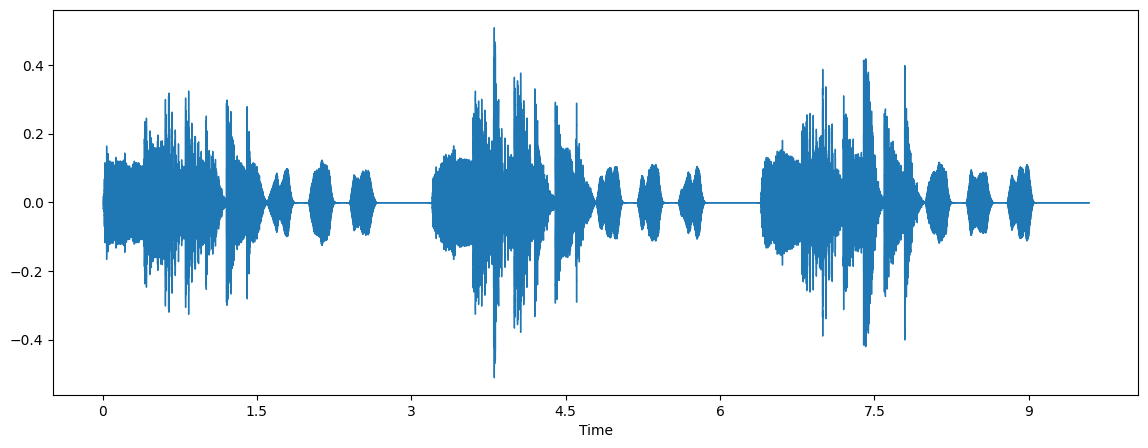

In [13]:
import IPython.display as ipd

# проигрывание аудио и визуализация
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
ipd.Audio(audio_data)

##### Разделение гармонических (тональных) и ударных (переходных) сигналов на две формы волны

Гармонические и ударные сигналы — это два типа звуков, которые имеют различные характеристики:
- Гармонические сигналы обладают спектральной разрежённостью (узкополосные звуки) и временной плавностью (устойчивые звуки).
- Ударные сигналы обладают спектральной плавностью (широкополосные звуки) и временной разрежённостью (переходные звуки).

Text(0.5, 1.0, 'Harmonic + Percussive')

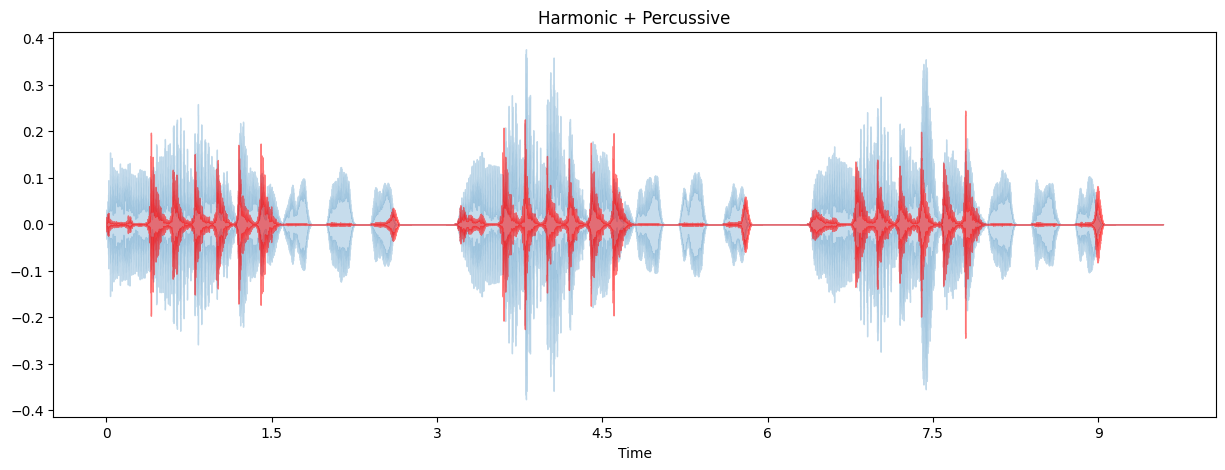

In [18]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25) # гармонические - светло-синий
librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5) # ударные - красные
plt.title('Harmonic + Percussive')

##### Извлечение битов - Beat
Beat (бит) трек на ударном сигнале. От англ. beat – один удар бочки - отрезок времени, ритм. Так, в одном такте 4 бита, например. Такт логичное деление битов. Обычно в такте 3 или 4 бита, хотя возможны и другие варианты.

Этот график представляет собой визуализацию временных интервалов между битами в музыкальном треке:
- Ось X представляет собой последовательность битов в треке, начиная с первого. 
- Ось Y - "Time difference (s)" - разница во времени (в секундах) между каждым битом и предыдущим.
 
Каждый столбец представляет собой интервал времени между двумя соседними битами. Высота столбца соответствует длительности этого интервала.

Обнаруженный темп: [151.99908088] beats/min


C:\Users\chesh\AppData\Local\Temp\ipykernel_7208\2558172962.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.barplot(x=beat_nums, y=beat_time_diff, palette="BuGn_d", ax=ax)


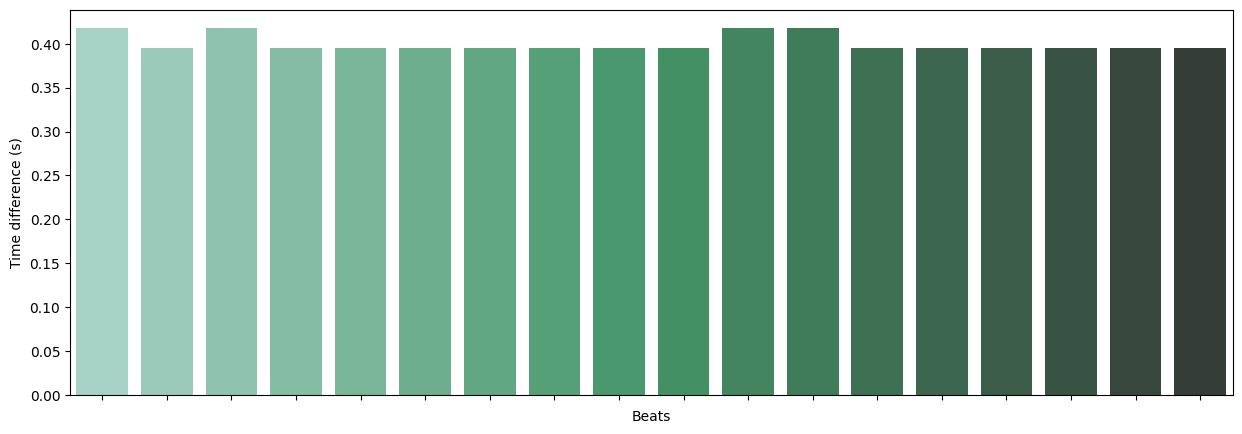

In [26]:
# Извлечение битов
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)
print('Обнаруженный темп: '+str(tempo)+ ' beats/min')

beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times)) # 18 битов за 9 секунд выделено

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot(x=beat_nums, y=beat_time_diff, palette="BuGn_d", ax=ax)
g=g.set(xticklabels=[])

##### Нормализованная энергия цветности (CENS, Chroma Energy Normalized) 

Это метод, который помогает анализировать музыку, как если бы мы смотрели на цветные картинки.

Представь, что каждая нота — это как цвет на палитре. CENS помогает увидеть, как энергия музыки распределяется между разными нотами в течение времени. Это позволяет понять, как меняется мелодия и аккорды, даже если исполнение отличается.

Например, два разных музыканта могут играть одну и ту же мелодию, но делать это по-разному — один может играть быстрее, другой — медленнее. CENS помогает сравнить их исполнения и увидеть, что общего между ними, даже если они звучат по-разному. Это как если бы ты смотрел на два разных изображения, но мог понять, что они изображают одно и то же!

Эта диаграмма показывает хромаграмму — визуализацию распределения энергии по 12 нотам (или цветам) в течение времени.
- Ось X (время) представляет время в аудиосигнале. Каждая отметка вдоль этой оси соответствует определенному моменту в музыке (9 секунд). 
- Ось Y (хрома) соответствует 12 нотам (или цветам) в октаве. Обычно это ноты от C до B.
- Цвета на диаграмме показывают уровень энергии (интенсивность) для каждой ноты в каждом моменте времени. Более яркие цвета (например, желтые или красные) означают больше энергии, а более темные (например, синие или черные) — меньше.

Как использовать диаграмму:
- Выделение пиков (яркие цвета означают, что в этот момент звучат определенные ноты с высокой энергией)
- Визуальное отображение изменчивости аудио (можно видеть, как ноты меняются с течением времени, что может показать изменения в мелодии или гармонии)
- Выделение паттернов (определенные последовательности нот могут повторяться, что помогает выявить структуру музыки)

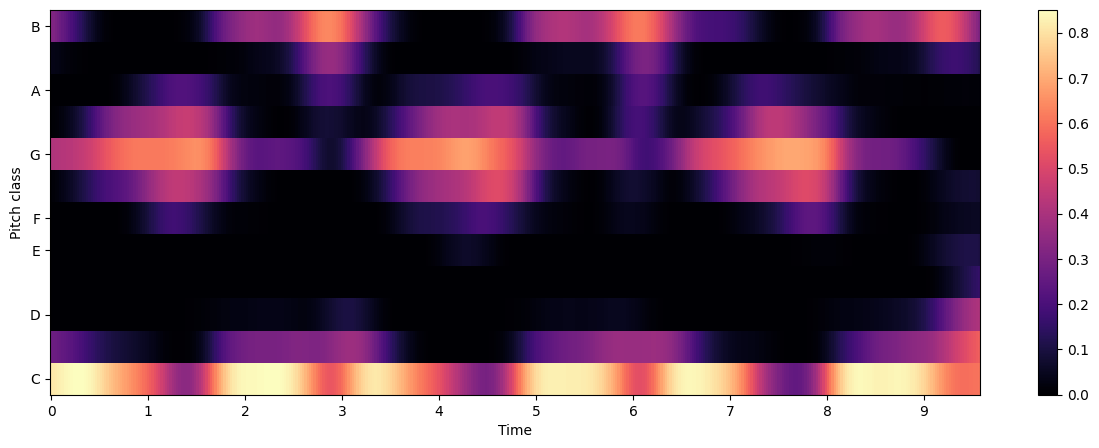

In [28]:
chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()

##### Спектрограмма
Спектрограмма - это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты.

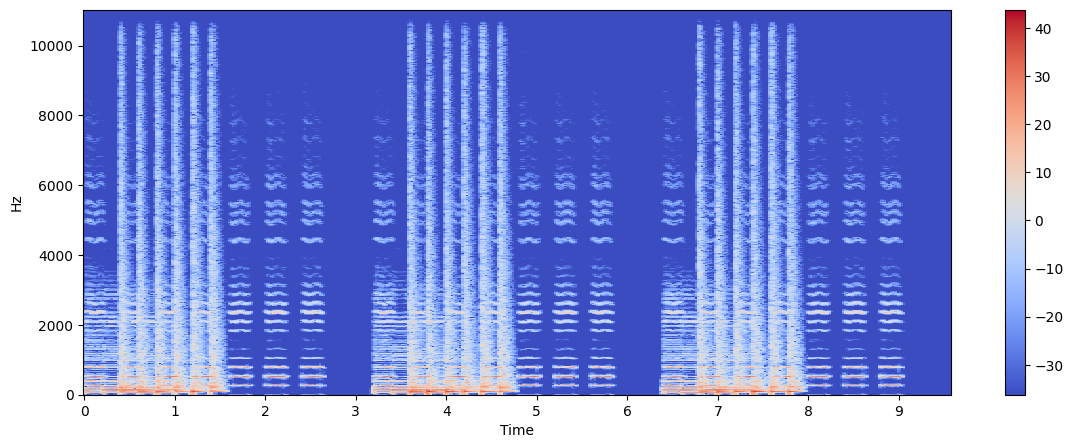

In [29]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Поскольку все действие происходит в нижней части спектра, мы можем преобразовать ось частот в логарифмическую

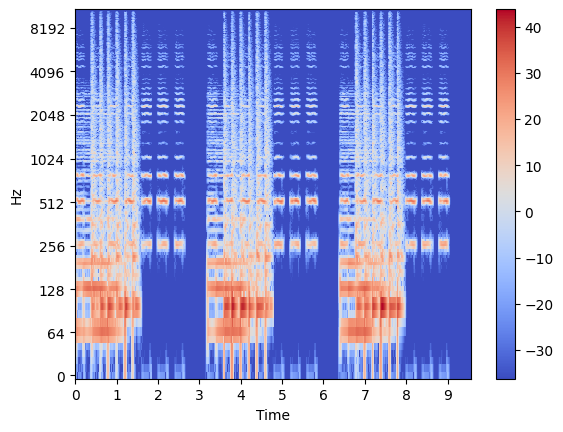

In [30]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

Есть большое количество и иных методов, которые используют для разложения аудио записи на различные компоненты. Сюда можно отнести:
- Мел-кепстральные коэффициенты (MFCC) — один из важнейших признаков в обработке аудио. MFCC — это матрица значений, которая захватывает тембральные аспекты.
- Спектральный центроид - Spectral Centroid. Указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен “центр масс” для звука
- Спектральный контраст - Spectral Contrast. Для каждого поддиапазона энергетический контраст оценивается путем сравнения средней энергии в верхнем квантиле (энергия пика) со средним значением энергии в нижнем квантиле (энергия впадины).
- Спектральный спад - Spectral Rolloff. Это мера формы сигнала, представляющая собой частоту, в которой высокие частоты снижаются до 0/
- И другие

##### Нормализация громкости и фильтрация (удаление шумов)

In [31]:
def normalize_audio(audio, target_db=-20):
    audio_db = librosa.amplitude_to_db(np.abs(audio)) # Преобразуем аудио в децибелы
    current_db = np.mean(audio_db)

    # Определяем коэффициент нормализации
    normalization_factor = target_db - current_db

    normalized_audio = librosa.db_to_amplitude(audio_db + normalization_factor)
    return normalized_audio

normalized_audio = normalize_audio(y)

In [33]:
def lowpass_filter(audio, cutoff=3000, fs=22050):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(1, normal_cutoff, btype='low', analog=False)
    filtered_audio = scipy.signal.filtfilt(b, a, audio)
    return filtered_audio

filtered_audio = lowpass_filter(normalized_audio)

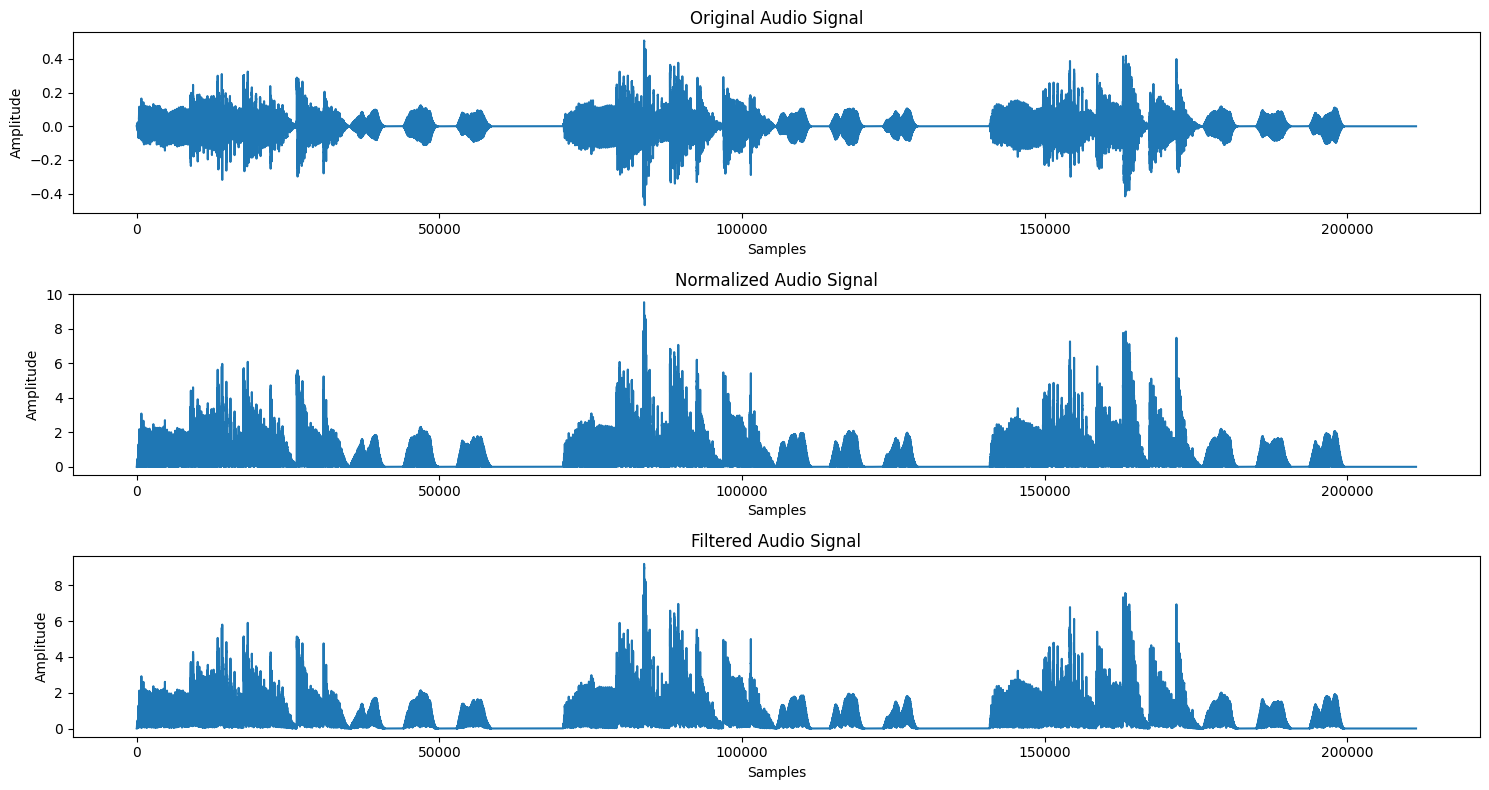

In [35]:
def plot_signals(original, normalized, filtered, sr):
    plt.figure(figsize=(15, 8))

    # Временные ряды
    plt.subplot(3, 1, 1)
    plt.title('Original Audio Signal')
    plt.plot(original)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.title('Normalized Audio Signal')
    plt.plot(normalized)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.title('Filtered Audio Signal')
    plt.plot(filtered)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

plot_signals(y, normalized_audio, filtered_audio, sr)